In [1]:
import cv2 
import numpy as np 
import matplotlib.pyplot as plt
import random 
import time

In [4]:
def lerVideo(caminho):
    cap = cv2.VideoCapture(caminho)
    frames = []

    if not cap.isOpened():
        raise("Erro abrindo o arquivo!")

    while True: 
        ret, frame = cap.read()

        if not ret:
            print("Último frame ou erro")
            break

        frames.append(frame)

        if cv2.waitKey(1) == ord('q'):
            break
        

    print("Leitura completa")
    cap.release()
    return np.array(frames)

In [18]:
frames = lerVideo('EAFC24.mp4')

Último frame ou erro
Leitura completa


In [11]:
def reproduzirVideo(frames):
    for frame in frames:
        cv2.imshow("Sem fundo", frame)
        
        if cv2.waitKey(1) == ord('q'):
            break

        time.sleep(1/30)

    cv2.destroyAllWindows()


### Filtrando apenas objetos brancos e (roxos)

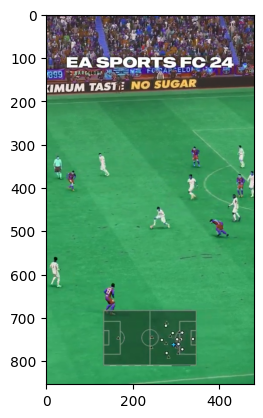

In [6]:
img_teste = frames[400]

plt.imshow(img_teste)
plt.show()

In [7]:
def onlyWhite(img, sensitivity=90, k_size = 3):
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_white = np.array([0, 0, 255 - sensitivity])
    upper_white = np.array([255, sensitivity, 255])

    mask = cv2.inRange(img_hsv, lower_white, upper_white)

    #Openning na imagem 
    kernel = np.ones((k_size, k_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask
    
    
    #kernel = np.ones((k_size, k_size))
    #mask_opening = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    #result = cv2.bitwise_and(img, img, mask=mask_opening)

    #return result


In [ ]:
#frames= lerVideo('EAFC24.mp4')

Último frame ou erro
Leitura completa


In [8]:
apenas_brancos = np.array([onlyWhite(frame, 110, k_size=2) for frame in frames])

In [41]:
reproduzirVideo(apenas_brancos)


#### Retirando o fundo do vídeo
Utilizando a diferença de frame em relação ao anterior

$Foreground = | I_t - I_{t-1} | > T$

In [13]:
def difFrames(frames): 
    n = frames.shape[0];
    print(n) 
    dif = []
    for i in range(n-1, 0, -1):
        #print(i, i-1)
        dif.append(cv2.absdiff(frames[i], frames[i-1]))

    return np.array(dif[::-1])

In [14]:
dif = difFrames(frames)

982


### Usando a mediana para subtrair o fundo 
$Foreground_t = |I_t - B | > T $, onde $B = median(I_1, I_2, ... , I_k)$

In [47]:
def difFramesMedian(frames, k, threshold=30):
    newFrames = [] 
    background_frames = frames[-k:]
    median_frame = np.median(background_frames, axis = 0).astype(np.uint8)


    for i, frame in enumerate(frames):
        abs_diff = cv2.absdiff(frame, median_frame)

        #abs_diff = cv2.cvtColor(abs_diff, cv2.COLOR_BGR2GRAY)
        
        _, foreground_mask = cv2.threshold(abs_diff, threshold, 255, cv2.THRESH_BINARY)

        newFrames.append(foreground_mask)

    return np.array(newFrames)

In [ ]:
#for k in [30, 60, 90, 120]:
#    dif = difFramesMedian(frames, k, 110)
#    reproduzirVideo(dif)

In [16]:
dif = difFramesMedian(apenas_brancos, k = 250, threshold = 230)

In [48]:
reproduzirVideo(dif)

In [42]:
def evaluateKmeans(img, k=2):
    image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # reshape the image to a 2D array of pixels and 3 color values (RGB)
    pixel_values = image.reshape((-1, 3))
    # convert to float
    pixel_values = np.float32(pixel_values)

    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # number of clusters (K)
    
    _, labels, (centers) = cv2.kmeans(pixel_values, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # convert back to 8 bit values
    centers = np.uint8(centers)

    # flatten the labels array
    labels = labels.flatten()


    # convert all pixels to the color of the centroids
    segmented_image = centers[labels.flatten()]

    # reshape back to the original image dimension
    segmented_image = segmented_image.reshape(image.shape)
    # show the image
    #plt.imshow(segmented_image)
    #plt.show()
    return segmented_image

In [55]:
def aplicarKmeanFrames(frames, k =2): 
    return np.array([evaluateKmeans(img, k) for img in frames])
    

In [50]:
img = frames[400]

In [54]:
def recortaCampo(frames):
    new_frames = np.array([img[200: , :, :] for img in frames])
    return new_frames
    

### Pipeline de procesamento

In [64]:
frames = lerVideo('EAFC24.mp4')
frames = recortaCampo(frames)


apenas_brancos = np.array([onlyWhite(frame, 110, k_size=2) for frame in frames])
final = aplicarKmeanFrames(apenas_brancos, k =2)
dif = difFramesMedian(final, k = 250, threshold = 230)





Último frame ou erro
Leitura completa


In [65]:
reproduzirVideo(dif)

In [69]:
dif = dif*frames


In [70]:
reproduzirVideo(dif)
